In [45]:
#загружаем библиотеки
import pandas as pd
import json
from ast import literal_eval as le
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline
import time

In [46]:
#экспортируем сырые данные, смотрим info
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Этап 1. Предобработка данных по выбранным переменным

### Определили значащие переменные:  
status R  
private pool and PrivatePool R  
propertyType R  
baths R  
homeFacts R  
fireplace R  
city V  
schools V  
sqft V  
beds V  
stories V  
target V

## target(цена)  
целевая перменная, начнём с неё

In [47]:
#посмотрим на пустые ячейки
df['target'].isnull().value_counts()

False    374704
True       2481
Name: target, dtype: int64

In [48]:
#убираем пустые(их немного, это радует)
df = df.dropna(subset=['target'])

In [49]:
#убедимся что в значения, нет '.', (центов)
df['target'].str.contains('.', regex = False).value_counts()

False    374704
Name: target, dtype: int64

In [50]:
#преобразовываем с помощью regex значения в int
df['target'] = df.target.replace('\D', '', regex=True).astype(int)

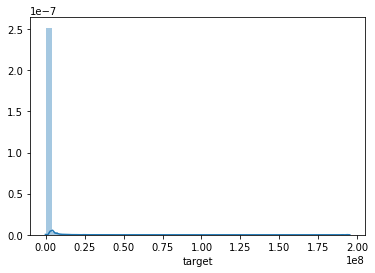

In [51]:
#цена имеет огромный диапазон значений за счёт выбросов.
#скорее всего в датасете не только целевой тип: дом, но и другие сооружения: апартаменты, квартиры, замки, земля и т.д.
#при работе с propertyType нужно это учесть
sns.distplot(df['target'])

In [52]:
#посмотрим на 'края' и уберём их
x = df['target'].quantile(.03)
y = df['target'].quantile(.88)
print(x)
print(y)
df['target'] = df['target'].where(df['target'] >= x)
df['target'] = df['target'].where(df['target'] <= y)
df = df.dropna(subset=['target'])

20000.0
998000.0


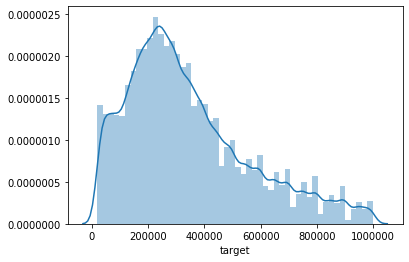

In [53]:
sns.distplot(df['target'])

## sqft (площадь)  
важнейшая переменная, которая должна определить точность модели

In [54]:
#посмотрим на пустые ячейки
df['sqft'].isnull().value_counts()

False    289958
True      28722
Name: sqft, dtype: int64

In [55]:
#плохая новость: пропуски есть, хорошая: их снова немного. Убираем: данных всё ещё достаточно для модели
df = df.dropna(subset=['sqft'])

In [56]:
#проводим манипуляции по переводу в int
df['sqft'] = df.sqft.replace('\D', '', regex=True)
df['sqft'] = df.sqft.replace('', None, regex=True)
df['sqft'] = df.sqft.replace('\D', '', regex=True).astype(int)

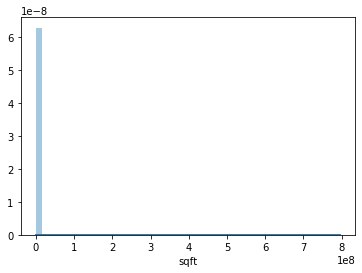

In [57]:
#смотрим: данные также имею широкий диапазон из-за выбросов. Нужно обрезать
sns.distplot(df['sqft'])

In [58]:
#Нулевая площадь нам не нужна, избавляемся
indexNames = df[df['sqft'] == 0 ].index
df.drop(indexNames, inplace=True)

In [59]:
#посмотрим на 'края' и уберём их
x = df['sqft'].quantile(.03)
y = df['sqft'].quantile(.95)
print(x)
print(y)
df['sqft'] = df['sqft'].where(df['sqft'] >= x)
df['sqft'] = df['sqft'].where(df['sqft'] <= y)
df = df.dropna(subset=['sqft'])

700.0
3731.0


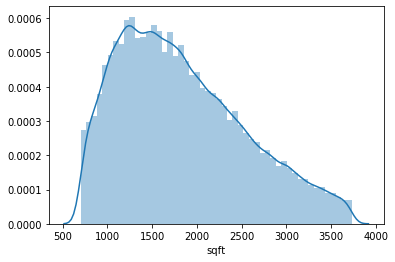

In [60]:
sns.distplot(df['sqft'])

## city (город)  
само наименование города ничего не даёт, попробуем заменить метриками

In [61]:
#посмотрим на пустые ячейки
df['city'].isnull().value_counts()

False    259615
Name: city, dtype: int64

In [62]:
#подготовим данные из серии city
df = df.dropna(subset=['city'])
df['city'] = df['city'].str.lower()

In [63]:
#с kaggle взят dataset c количеством преступлений по городам за последние 2 года.
#преобразуем данные для нашего dataset
city = pd.read_excel('city_crime.xlsx')
city = city.dropna()
city['City'] = city['City'].str.lower()
del city['State']
city['crimes_pop'] = 0
for i in city.columns[3:]:
    city['crimes_pop'] += city[i]
    del city[i]
    if i == 'Arson':
        city['crimes_pop'] = city['crimes_pop'] / city['Population']
        break
del city['Year']
city['City'] = city['City'].str.lower()
city_crime = city.groupby(['City']).mean()

In [64]:
#мы получили метрики: средний за два года уровень преступности по городам, популяция 
city_crime.head(3)

,Population,crimes_pop
City,,
abilene,122480.0,0.032173
akron,197690.0,0.040652
albuquerque,560235.0,0.072329


In [65]:
df_new = pd.merge(df, city_crime, how='left', left_on='city', right_on='City')

In [66]:
#потеряли много данных, но получили две новые метрики. Будем считать это хорошим обменом.
df_new['crimes_pop'].isnull().value_counts()
df_new = df_new.dropna(subset=['crimes_pop'])
df = df_new

## beds (спальни)  
показатель похож на площадь. Посмотрим, что там и решим, нужна ли нам эта метрика

In [67]:
#посмотрим на пустые ячейки
df['beds'].isnull().value_counts()
df = df.dropna(subset=['beds'])
df['beds'] = df['beds'].str.lower()

In [68]:
#преобразуем данные (int, т.к. количество спален должно быть целым)
df['beds'] = df.beds.replace('.0', '', regex=True)
df['beds'] = df.beds.replace('\D', '', regex=True)
df['beds'] = df.beds.replace('', None, regex=True)
df['beds'] = df.beds.replace('\D', '', regex=True).astype(int)
df['beds'] = df['beds'].where(df['beds'] != 0)
df = df.dropna(subset=['beds'])

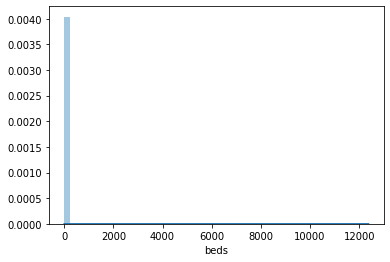

In [69]:
#также может наблюдать явные выбросы. 12000 спален...
sns.distplot(df['beds'])

In [70]:
#минимальное количество = 1 спальня, а вот макисмальное опредилим квантилем .99
y = df['beds'].quantile(.99)
print(y)
df['beds'] = df['beds'].where(df['beds'] <= y)

6.0


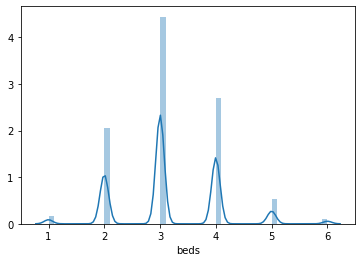

In [71]:
#другое дело
sns.distplot(df['beds'])

## stories (этажность)  
многоэтажные дома, должны быть дороже. Но, опять же, это связанный с площадью параметр

In [72]:
#посмотрим на пустые ячейки
df['stories'].isnull().value_counts()

False    89677
True     28491
Name: stories, dtype: int64

In [73]:
#преобразуем данные (int, т.к. количество этажей должно быть целым)
df = df.dropna(subset=['stories'])
df['stories'] = df['stories'].str.lower()
df['stories'] = df.stories.replace('.0+', '', regex=True)
df['stories'] = df.stories.replace('\D', '', regex=True)
df['stories'] = df.stories.replace('', None, regex=True)
df['stories'] = df.stories.replace('\D', '', regex=True).astype(int)
df['stories'] = df['stories'].where(df['stories'] != 0)
df = df.dropna(subset=['stories'])

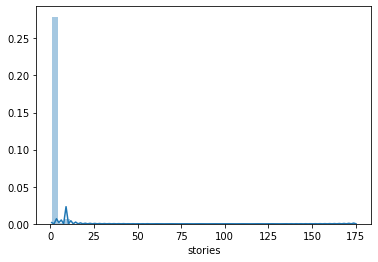

In [74]:
#ну и тут разброс конечно
sns.distplot(df['stories'])

In [75]:
#минимальное количество = 1 этаж, а вот макисмальное также опредилим квантилем .99
y = df['stories'].quantile(.99)
print(y)
df['stories'] = df['stories'].where(df['stories'] <= y)

9.0


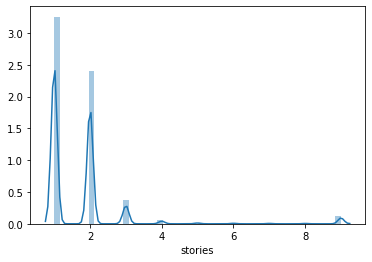

In [76]:
#оставил немного данных о высокоэтажных домах
sns.distplot(df['stories'])

## schools (школы)  
Один из самых интересных парамтеров. В данных словари, содержащие в себе информацию о близлежащих  
к продаваемому дому школах. Это такие данные как: тип школы, расстояние от дома до школы, рейтинг школы  
и название школы. Я решил парсить словарь и получить из него следующие дополнительные метрики:  
количество близлежащих школ  
среднее расстояние до них  
средний рейтинг этих школ

In [77]:
#Напишем функции для преобразования

#функция для количества школ
def school_count(value):
    try:
        x = len(pd.DataFrame(dict(le(value)[0])['data']))
        return int(x)
    except:
        return 0
    
#функция для среднего расстояния
def school_distance(value):
    try:
        x = pd.DataFrame(dict(le(value)[0])['data']).Distance.replace('\D*mi', '', regex=True).astype(float).mean()
        return x
    except:
        return 0
    
#функция для среднего рейтинга
def school_rt(value):
    try:
        s = pd.Series(dict(le(value)[0])['rating'])
        s = s.replace('/10', '', regex=True)
        s = s.replace('\D+', '0', regex=True).astype(int)
        s = s.where(s != 0)
        s = s.dropna()
        x = s.mean()
        return x
    except:
        return 0

In [78]:
#замерим скорость каждой операции и определим порядок парсинга(т.к. в процессе данные будем убирать,
# чем ускорим обработку низкоскоростных операций):
%timeit school_count(df['schools'][17])

691 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
%timeit school_distance(df['schools'][17])

1.3 ms ± 66.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
%timeit school_rt(df['schools'][17])

1.56 ms ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [81]:
#убедимся, что в оставшемся датасете нет пропусков в школах
df['schools'].isnull().value_counts()

False    83967
Name: schools, dtype: int64

In [82]:
#парсим количество школ
df['school_count'] = df['schools'].progress_apply(school_count)

100%|██████████████████████████████████████████████████████████████████████████| 83967/83967 [00:56<00:00, 1488.05it/s]


In [83]:
#'0' в значениях говорит скорее о неудачном парсинге, чем об отсутсвии школ, поэтому избавимся от них.
# также уберём .5 и .95 квантили
df['school_count'] = df['school_count'].where(df['school_count'] != 0)
x = df['school_count'].quantile(.05)
y = df['school_count'].quantile(.95)
df['school_count'] = df['school_count'].where(df['school_count'] >= x)
df['school_count'] = df['school_count'].where(df['school_count'] <= y)
df = df.dropna(subset=['school_count'])
len(df)

78465

In [84]:
#парсим расстояние
df['school_distance'] = df['schools'].progress_apply(school_distance)

100%|███████████████████████████████████████████████████████████████████████████| 78465/78465 [01:37<00:00, 801.83it/s]


In [85]:
#уберём ошибки, обрежем края
df['school_distance'] = df['school_distance'].where(df['school_distance'] != 0)
x = df['school_distance'].quantile(.05)
y = df['school_distance'].quantile(.95)
df['school_distance'] = df['school_distance'].where(df['school_distance'] >= x)
df['school_distance'] = df['school_distance'].where(df['school_distance'] <= y)
df = df.dropna(subset=['school_distance'])
len(df)

70641

In [86]:
#парсим рейтинг
df['school_rt'] = df['schools'].progress_apply(school_rt)

100%|███████████████████████████████████████████████████████████████████████████| 70641/70641 [01:55<00:00, 613.16it/s]


In [87]:
df['school_distance'] = df['school_distance'].where(df['school_distance'] != 0)
df = df.dropna(subset=['school_rt'])
len(df)

70490

# Этап 2. Визуализация и анализ данных.

#### Площадь и цена
видна зависимость цены и площади:

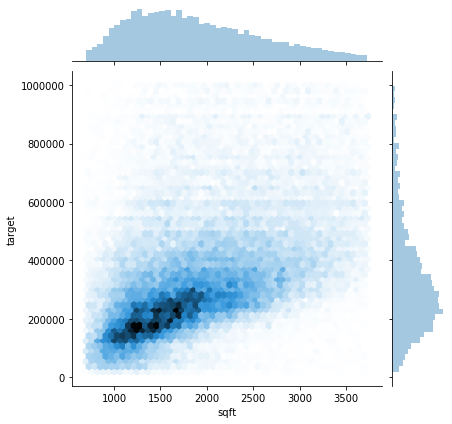

In [88]:
sns.jointplot(x='sqft', y='target', data=df, kind='hex')

#### Города и цена

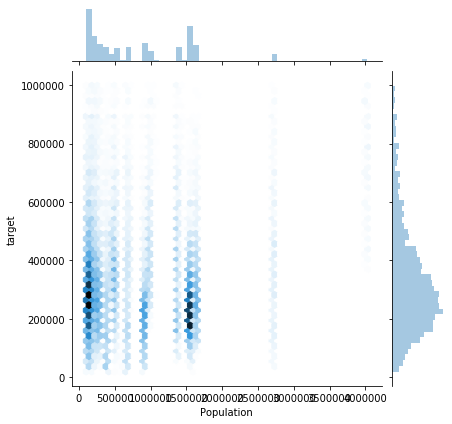

In [89]:
#В городах с высокой популяцией в основном только дорогое жилье.
#Основной массив: частные небольшие и относительно недорогие дома в маленьких городках.
sns.jointplot(x='Population', y='target', data=df, kind='hex')

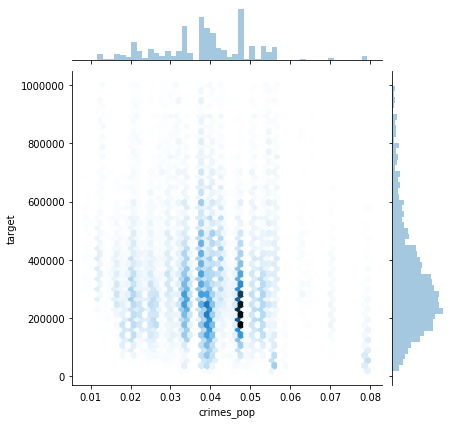

In [90]:
#Города с высоким уровнем преступности имеют только низкую стоимость жилья
#Основная масса: средний уровень преступности (0.4-0.5)
sns.jointplot(x='crimes_pop', y='target', data=df, kind='hex')

#### Спальни, этажность и цена

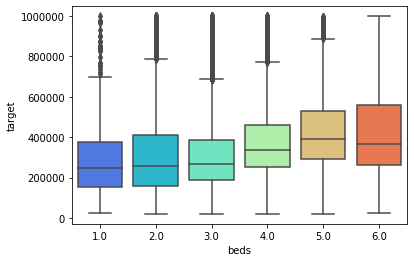

In [91]:
#Цена при увеличении спален растёт.
sns.boxplot(x='beds', y='target', data=df, palette='rainbow')

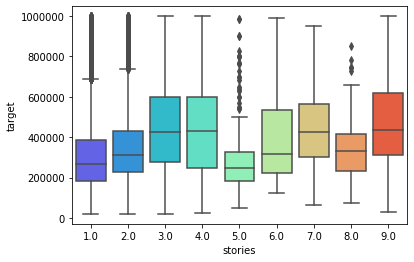

In [92]:
#Цена при увеличении количества этажей растёт.
sns.boxplot(x='stories', y='target', data=df, palette='rainbow')

#### Школы и цена

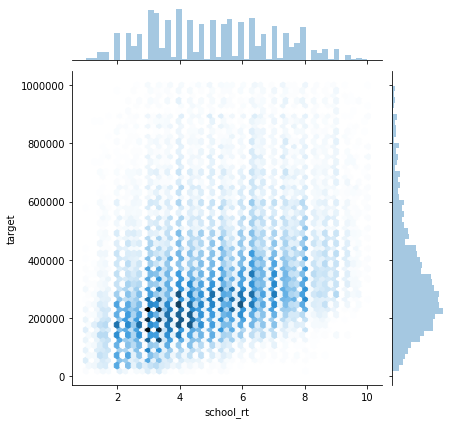

In [93]:
#Из полученных метрик хочется выделить средний рйтинг. Видна хорошая зависимость цены.
sns.jointplot(x='school_rt', y='target', data=df, kind='hex')

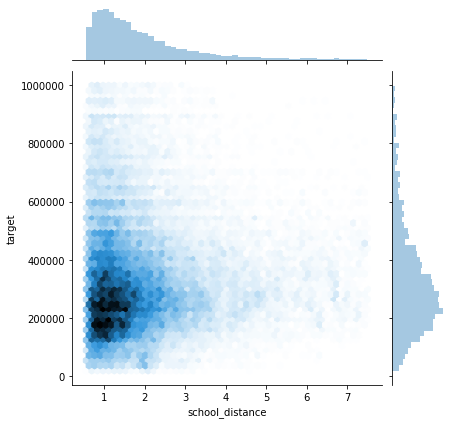

In [94]:
#Как мы ранее выяснили основу наших данные составляют небольшие дома в маленьких городках.
#Очевидно и расстояния до школ будут не большими: в пределах 2-ух миль, практически у всех домов.
# отметить стоит, что у жилья со стоимостью больше 600 тыс. школы находятся не дальше 4-5 миль.
sns.jointplot(x='school_distance', y='target', data=df, kind='hex')

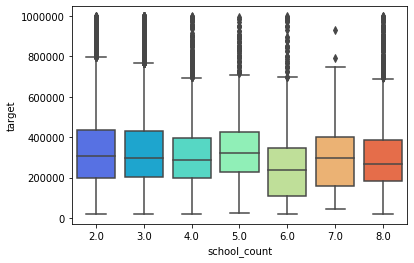

In [95]:
#в целом распределение по количеству школ не отличается от общего распределения данных по цене, зависимости нет.
#кроме этого можно увидеть, что дома, рядом с которыми есть 6 школ, почему-то ниже в цене.
# Это может запутать модель, поэтому этц метрику включать не будем
sns.boxplot(x='school_count', y='target', data=df, palette='rainbow')